# Projeto Final - Algotrading
### Vinícius Matheus Morales

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime, random
from dateutil.relativedelta import relativedelta
import pandas_ta as ta

# Para fazer o backtesting
from backtesting import TradingSystem, MarketData, Order, Strategy, Event, evaluateHist


In [2]:
# Bloco para gerar um dia útil aleatório entre 5 a 10 anos atrás

# Função para conferir se o dia dado é útil
is_bday = lambda date: bool(len(pd.bdate_range(date, date)))

# Dia útil mais próximo de hoje
today = datetime.date.today()
while not is_bday(today):
    today -= datetime.timedelta(days=1)

# Enquanto não for um dia útil, gerar novamente um ano aleatório
start_date = today - relativedelta(years=random.choice(list(range(5, 11))))
while not is_bday(start_date):
    start_date -= datetime.timedelta(days=1)
    
print(f'O dia útil no qual iniciará o teste é: {start_date.strftime("%d/%m/%Y")}')
print(f'O dia útil mais próximo de hoje é: {today.strftime("%d/%m/%Y")}')

today = str(today)
start_date = str(start_date)
end_date = today


O dia útil no qual iniciará o teste é: 16/06/2017
O dia útil mais próximo de hoje é: 17/06/2022


In [3]:
import yahoofinancials as yf
ticker = 'AAPL'

data = yf.YahooFinancials(ticker).get_historical_price_data(start_date, end_date, 'daily')

# Ler os dados do JSON
raw = pd.DataFrame(data[ticker]['prices']).dropna()
# Converter a data para o tipo correto datetime
raw['formatted_date'] = pd.to_datetime(raw['formatted_date'])
# Indica a data como o índice de cada linha
raw = raw.set_index('formatted_date')
# Removendo as colunas que não interessam
df = raw.iloc[:,1:]

# Acertando a ordem das colunas
df = df.reindex(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume'])
# Salvando o CSV
df.to_csv(f'{ticker}.csv')


In [4]:
df


,open,high,low,close,adjclose,volume
formatted_date,,,,,,
2017-06-16,35.945000,36.125000,35.549999,35.567501,33.670544,201444400
2017-06-19,35.915001,36.685001,35.915001,36.584999,34.633778,130165600
2017-06-20,36.717499,36.717499,36.235001,36.252499,34.319008,99600400
2017-06-21,36.380001,36.517502,36.152500,36.467499,34.522545,85063200
2017-06-22,36.442501,36.674999,36.279999,36.407501,34.465748,76425200
...,...,...,...,...,...,...
2022-06-10,140.279999,140.759995,137.059998,137.130005,137.130005,91437900
2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300


In [5]:
help(ta.pvt)


Help on function pvt in module pandas_ta.volume.pvt:

pvt(close, volume, drift=None, offset=None, **kwargs)
    Price-Volume Trend (PVT)
    
    The Price-Volume Trend utilizes the Rate of Change with volume to
    and it's cumulative values to determine money flow.
    
    Sources:
        https://www.tradingview.com/wiki/Price_Volume_Trend_(PVT)
    
    Calculation:
        Default Inputs:
            drift=1
        ROC = Rate of Change
        pv = ROC(close, drift) * volume
        PVT = pv.cumsum()
    
    Args:
        close (pd.Series): Series of 'close's
        volume (pd.Series): Series of 'volume's
        drift (int): The diff period. Default: 1
        offset (int): How many periods to offset the result. Default: 0
    
    Kwargs:
        fillna (value, optional): pd.DataFrame.fillna(value)
        fill_method (value, optional): Type of fill method
    
    Returns:
        pd.Series: New feature generated.



In [6]:
class PVT(Strategy):
    
    def __init__(self):
        
        self.period = 5
        
        self.side = 0
        
        self.prices = []
        self.volumes = []
        self.indicator = []
        
    def push(self, event):
        
        orders = []
        
        price = event.price[3] # Preço de fechamento
        volume = event.quantity # Volume
        
        # Montando a série de preços
        self.prices.append(price)
        
        # Montando a série de volumes
        self.volumes.append(volume)
        
        if len(self.prices) > self.period:
            data = pd.DataFrame({'close': self.prices,
                                 'volume': self.volumes})

            pvt = data.ta.pvt(data['volume'], drift=self.period)

            self.indicator.append(pvt.iloc[-1])

            # Se o indicador estiver subindo e os preços caindo, comprar
            if pvt.iloc[-2] < pvt.iloc[-1] and self.prices[-2] > self.prices[-1]:
                signal = 1
            # Se o indicador estiver caindo e os preços subindo, vender
            elif pvt.iloc[-2] > pvt.iloc[-1] and self.prices[-2] < self.prices[-1]:
                signal = -1
            else:
                signal = self.side

            # Ajustando a posição
            if self.side != signal:
                orders.append(Order(event.instrument, -self.side, 0))
                orders.append(Order(event.instrument, signal, 0))
                self.side = signal
            
        return orders

modelPVT = PVT()
print(evaluateHist(modelPVT, {ticker: f'{ticker}.csv'}))



Number of trades: 133
Gross P&L: 49.10
Gross Accumulated return: 0.43%
Gross Average Return: 0.55%
Net P&L: 49.06
Hitting ratio: 47.37%
Max Profit: 23.30
Max Drawdown: -14.82



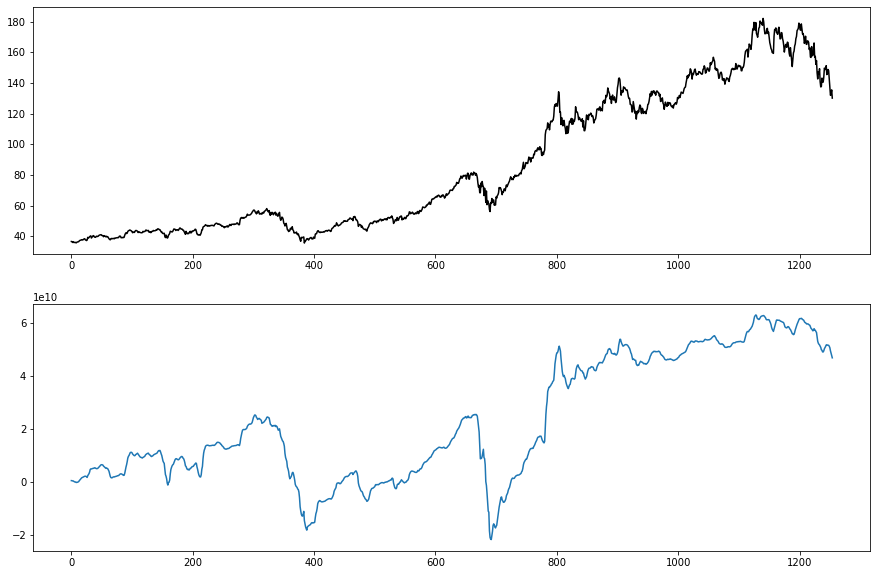

In [7]:
# Plot do gráfico
fig, ax = plt.subplots(2, 1, figsize=(15, 10));

ax[0].plot(modelPVT.prices[-len(modelPVT.indicator):], color='black');
ax[1].plot(modelPVT.indicator);
